# Курсовой проект


Импортируем все необходимые для работы библиотеки

In [12641]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12642]:
import warnings
warnings.filterwarnings('ignore')

Делаем одинаковый шрифт для всех графиков


In [12643]:
matplotlib.rcParams.update({'font.size': 14})

Создаем функцию для построения граффиков r2 на train и валидационной выборки для сравнения.

In [12644]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Прописываем путь к нашим данным

In [12645]:
# Почему то когда читаю фаил по ссылке программа падает, поэтому загрузила файлы в ноутбук.
# TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
# TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [12646]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [12647]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12648]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12649]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [12650]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# EDA

#### Целевая переменная

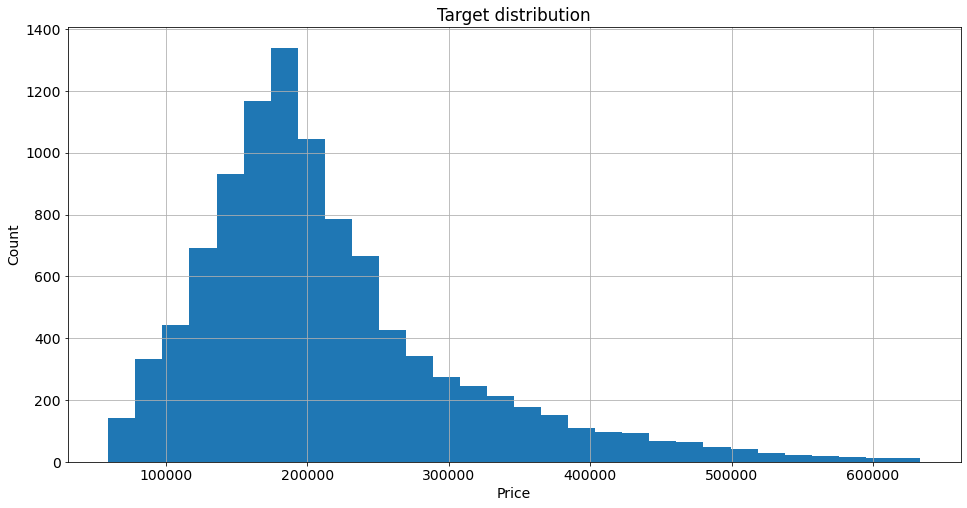

In [12651]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [12652]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [12653]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### Рассмотрим каждую переменную в отдельности

#### Rooms

In [12654]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [12655]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [12656]:
train_df.loc[(train_df['Rooms'] >= 6), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


Значение признака 'Rooms' выше 5 скорее всего выброс, т.к. как минимум общая площадь при таком количестве комнат должна быть значительно больше....

In [12657]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [12658]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [12659]:
train_df['Square'].value_counts()

26.553188     1
46.363496     1
100.751999    1
70.726600     1
40.523022     1
             ..
76.481158     1
86.915187     1
82.482521     1
43.112986     1
97.664912     1
Name: Square, Length: 10000, dtype: int64

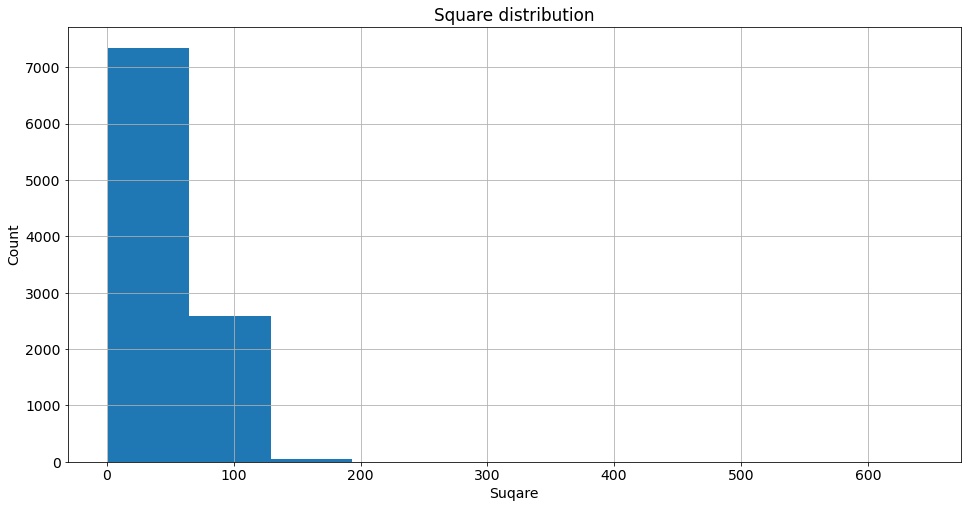

In [12660]:
plt.figure(figsize = (16, 8))

train_df['Square'].hist(bins=10)
plt.ylabel('Count')
plt.xlabel('Suqare')

plt.title('Square distribution')
plt.show()


Среди значений данного признака есть значения меньше 20 либо это комнаты, либо выбросы, рассмотрим их подробнее

In [12661]:
(train_df['Square'] < 20).value_counts()

False    9979
True       21
Name: Square, dtype: int64

In [12662]:
train_df.loc[(train_df['Square'] < 20)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.182323,0
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,...,B,9,1892,0,NaN,0,1,B,161379.067034,0
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,...,B,16,3433,4,2643.0,4,5,B,369472.403061,0
3686,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,...,B,49,11395,3,1406.0,3,4,A,77835.185808,0
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,458378.777006,0
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,...,B,15,2787,2,520.0,0,7,B,483283.488083,0
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,...,B,4,915,0,NaN,0,0,B,107604.269441,0
5870,6927,21,1.0,16.117154,8.822988,0.0,2,5.0,1965,0.194489,...,B,47,8004,3,125.0,3,5,B,79913.267856,0
6632,13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,...,B,25,4756,16,2857.0,5,8,B,88871.750230,0
7033,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,...,B,43,8429,3,NaN,3,9,B,412511.088764,0


При рассмотрении признака ближе мы увидели, что в некоторых объектах общая площадь больше жилой, в данной ситуации значению общей площади присвоим значение жилой. Добавим новый признак, позволяющий определить какие данные мы изменили

In [12663]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 300) | (train_df['Square'] <= train_df['LifeSquare']), 'Square_outlier'] = 1


In [12664]:
square_outliers = train_df.loc[(train_df['Square'] <= train_df['LifeSquare'])].index
square_outliers

Int64Index([  33,   64,   77,  100,  111,  142,  161,  165,  179,  213,
            ...
            9825, 9831, 9841, 9873, 9947, 9960, 9962, 9979, 9987, 9993],
           dtype='int64', length=482)

In [12665]:
train_df.loc[square_outliers, 'Square'] = train_df.loc[square_outliers, 'LifeSquare']


In [12666]:
square_outliers2 = train_df.loc[(train_df['Square']  < train_df['LifeSquare'])].index
square_outliers2

Int64Index([], dtype='int64')

Дальше заменим оставшиеся занчения признака < 20, на медиану

In [12667]:
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 300)] = train_df['Square'].median()

#### KitchenSquare

In [12668]:
train_df['KitchenSquare'].value_counts()

1.000000       2449
8.000000       1305
5.000000       1169
10.000000      1072
6.000000       1038
9.000000        843
0.000000        693
7.000000        608
12.000000       249
11.000000       233
13.000000        67
14.000000        51
4.000000         39
15.000000        31
52.633651        22
3.000000         21
16.000000        16
20.000000        14
17.000000        12
19.000000        11
18.000000         6
22.000000         3
2.000000          3
32.000000         2
112.000000        2
43.000000         2
51.000000         2
41.000000         2
58.000000         2
25.000000         2
37.000000         2
30.000000         2
53.000000         1
26.000000         1
78.000000         1
54.000000         1
29.000000         1
31.000000         1
35.000000         1
62.000000         1
39.000000         1
1970.000000       1
36.000000         1
60.000000         1
72.000000         1
27.000000         1
40.000000         1
96.000000         1
48.000000         1
21.000000         1


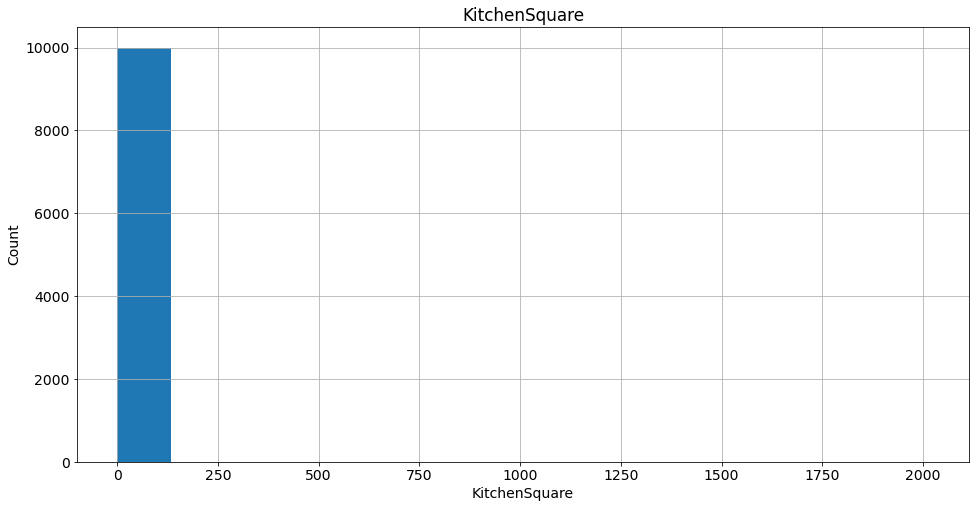

In [12669]:
plt.figure(figsize = (16, 8))

train_df['KitchenSquare'].hist(bins=15)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')

plt.title('KitchenSquare')
plt.show()

In [12670]:
train_df.loc[(train_df['KitchenSquare'] > 30), :]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
161,52.6337,52.6337,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,...,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.6337,52.633651,52.633651,52.633651
286,2737,27,3.000000,125.806981,125.806981,123.000000,5.000000,10.000000,2015.000000,0.017647,...,2.000000,469.000000,0.000000,NaN,0.000000,0.000000,B,234194.837047,0.000000,1.000000
328,52.6337,52.6337,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,...,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.6337,52.633651,52.633651,52.633651
456,10546,62,1.000000,46.013187,43.417043,43.000000,4.000000,17.000000,2019.000000,0.072158,...,2.000000,629.000000,1.000000,NaN,0.000000,0.000000,A,113909.099428,0.000000,0.000000
682,16593,52,2.000000,64.859242,NaN,62.000000,15.000000,17.000000,1977.000000,0.371149,...,34.000000,7065.000000,1.000000,750.000000,2.000000,5.000000,B,185993.474671,0.000000,0.000000
726,52.6337,52.6337,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,...,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.6337,52.633651,52.633651,52.633651
755,15781,10,1.000000,35.813564,19.953992,35.000000,6.000000,14.000000,1971.000000,0.282798,...,33.000000,8667.000000,2.000000,NaN,0.000000,6.000000,B,164306.314182,0.000000,0.000000
1401,52.6337,52.6337,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,...,52.633651,52.633651,52.633651,52.633651,52.633651,52.633651,52.6337,52.633651,52.633651,52.633651
1614,3267,58,3.000000,138.980817,138.004600,43.000000,2.000000,2.000000,1977.000000,0.437885,...,23.000000,5735.000000,3.000000,1084.000000,0.000000,5.000000,B,169528.896664,0.000000,0.000000
1728,16395,2,3.000000,79.722243,44.731219,72.000000,12.000000,16.000000,1987.000000,0.130618,...,39.000000,10418.000000,9.000000,900.000000,1.000000,9.000000,B,370148.625285,0.000000,0.000000


В данном признаке можно наблюдать следующие выбросы 'KitchenSquare' = 1 и больше 30, будем их обрабатывать для этого обозначим занчения призанка, которые будем менять, для этого добавим новый признак 'KitchenSquare_outlier'

In [12671]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[(train_df['KitchenSquare'] <= 1) | (train_df['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1


In [12672]:
train_df.loc[(train_df['KitchenSquare'] > 30), 'KitchenSquare'] = train_df['KitchenSquare'].median()


In [12673]:
train_df.loc[(train_df['KitchenSquare'] > 30), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier


Посмотрим на строки в которых значение признака равно 1

In [12674]:
train_df.loc[(train_df['KitchenSquare'] <= 1), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier
3,2352,1,1.0,40.409907,NaN,1.0,10.0,22.0,1977.0,0.007122,...,264.0,0.0,NaN,0.0,1.0,B,168106.007630,0.0,0.0,1
8,9951,1,1.0,46.887892,44.628132,1.0,12.0,20.0,1977.0,0.007122,...,264.0,0.0,NaN,0.0,1.0,B,160400.401732,0.0,0.0,1
9,8094,6,3.0,79.867477,75.085125,1.0,3.0,17.0,2014.0,0.243205,...,1564.0,0.0,540.0,0.0,0.0,B,194756.023945,0.0,0.0,1
18,4581,1,1.0,47.582480,NaN,1.0,16.0,16.0,1977.0,0.007122,...,264.0,0.0,NaN,0.0,1.0,B,128803.593810,0.0,0.0,1
19,367,45,1.0,42.367289,40.012529,1.0,16.0,14.0,2015.0,0.195781,...,5212.0,6.0,NaN,3.0,2.0,B,250466.980777,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,6753,62,2.0,73.092686,NaN,1.0,4.0,16.0,2017.0,0.072158,...,629.0,1.0,NaN,0.0,0.0,A,159077.198056,0.0,0.0,1
9982,10268,27,1.0,36.112393,1.855415,1.0,9.0,16.0,1977.0,0.211401,...,1892.0,0.0,NaN,0.0,1.0,B,94881.691800,0.0,0.0,1
9983,647,1,2.0,63.324025,NaN,1.0,4.0,17.0,1977.0,0.007122,...,264.0,0.0,NaN,0.0,1.0,B,183809.327114,0.0,0.0,1
9991,11173,6,2.0,62.648779,NaN,0.0,6.0,17.0,1977.0,0.243205,...,1564.0,0.0,540.0,0.0,0.0,B,182625.548872,0.0,0.0,1


Т.к. общая площадь у квартир, где значение признака меньше или равно 1 разная, выдвигаем гипотезу, что наблюдатель не знал площадь кухни, поэтому заполним эти значения медианой

In [12675]:
train_df.loc[(train_df['KitchenSquare'] <= 1), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [12676]:
train_df.loc[(train_df['KitchenSquare'] <= 1), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier


Рассмотрим ситуацию при которой площадь кухни занимает больше 33% общей площади

In [12677]:
((train_df['KitchenSquare']/train_df['Square']) >= 0.33).sum()

18

In [12678]:
train_df.loc[(train_df['KitchenSquare']/train_df['Square']) >= 0.33]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier
158,9880,27,1.0,48.175959,20.282928,16.0,2.0,14.0,2011.0,0.051815,...,1227.0,0.0,NaN,0.0,0.0,B,131073.658505,0.0,0.0,0
2180,5826,23,1.0,55.282148,11.168019,20.0,4.0,3.0,2013.0,0.014073,...,475.0,0.0,NaN,0.0,0.0,B,157140.848998,0.0,0.0,0
2307,5939,23,1.0,29.109535,28.952061,10.0,2.0,17.0,2018.0,0.034656,...,168.0,0.0,NaN,0.0,0.0,B,69237.912649,0.0,0.0,0
3125,8500,31,1.0,80.606246,25.299592,29.0,6.0,40.0,2014.0,0.151346,...,5889.0,10.0,830.0,4.0,1.0,B,460492.010947,0.0,0.0,0
3643,10581,27,2.0,42.336640,22.592711,16.0,3.0,5.0,1970.0,0.075424,...,3097.0,0.0,NaN,0.0,0.0,B,117533.550253,0.0,0.0,0
3976,16575,27,1.0,32.712359,11.047605,13.0,8.0,25.0,2016.0,0.072158,...,629.0,1.0,NaN,0.0,0.0,A,94433.038958,0.0,0.0,0
4931,3538,23,1.0,27.730287,27.730287,10.0,9.0,17.0,2016.0,0.034656,...,168.0,0.0,NaN,0.0,0.0,B,75695.826241,0.0,1.0,0
5404,15691,62,1.0,41.735073,12.423180,14.0,3.0,15.0,2010.0,0.072158,...,629.0,1.0,NaN,0.0,0.0,A,80331.107871,0.0,0.0,0
6676,6234,74,1.0,30.063248,12.208497,10.0,6.0,9.0,1972.0,0.309479,...,7715.0,4.0,990.0,0.0,6.0,B,133124.260377,0.0,0.0,0
6794,13288,161,1.0,50.808925,15.920343,20.0,8.0,9.0,1910.0,0.014423,...,3806.0,4.0,NaN,0.0,3.0,B,287954.720682,0.0,0.0,0


In [12679]:
kitchen_outliers = train_df.loc[(train_df['KitchenSquare']/train_df['Square']) >= 0.33].index
kitchen_outliers

Int64Index([ 158, 2180, 2307, 3125, 3643, 3976, 4931, 5404, 6676, 6794, 8237,
            8305, 8663, 9349, 9472, 9746, 9810, 9860],
           dtype='int64')

In [12680]:
train_df.loc[kitchen_outliers, 'KitchenSquare_outlier'] = 1
train_df.loc[kitchen_outliers, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [12681]:
((train_df['KitchenSquare']/train_df['Square']) >= 0.33).sum()

0

In [12682]:
train_df.loc[(train_df['KitchenSquare']/train_df['Square']) >= 0.33]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier


#### LifeSquare

По данному признаку есть следующие ситуации, на которые необходимо обратить внимание: есть пропуски и есть ситуации при которых площадь кухни равна общей площади. Эти ситуации необходимо обработать.

In [12683]:
train_df['LifeSquare'].isna()

0        True
1       False
2       False
3        True
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: LifeSquare, Length: 10000, dtype: bool

In [12684]:
train_df['LifeSquare_nan'] = 0
train_df.loc[(train_df['LifeSquare'].isna()) | (train_df['Square'] == train_df['LifeSquare']), 'LifeSquare_nan'] = 1


In [12685]:
condition1 = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())

train_df.loc[condition1, 'LifeSquare'] = train_df.loc[condition1, 'Square'] - train_df.loc[condition1, 'KitchenSquare'] - 3
        


In [12686]:
condition2 = train_df.loc[(train_df['Square'] == train_df['LifeSquare'])].index

train_df.loc[condition2, 'LifeSquare'] = train_df.loc[condition2, 'Square'] - train_df.loc[condition2, 'KitchenSquare'] - 3
        


In [12687]:
train_df.loc[(train_df['LifeSquare'].isna()) | (train_df['Square'] == train_df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_nan


#### HouseFloor, Floor

In [12688]:
train_df['HouseFloor'].sort_values().unique()

array([  0.        ,   1.        ,   2.        ,   3.        ,
         4.        ,   5.        ,   6.        ,   7.        ,
         8.        ,   9.        ,  10.        ,  11.        ,
        12.        ,  13.        ,  14.        ,  15.        ,
        16.        ,  17.        ,  18.        ,  19.        ,
        20.        ,  21.        ,  22.        ,  23.        ,
        24.        ,  25.        ,  26.        ,  27.        ,
        28.        ,  29.        ,  30.        ,  31.        ,
        32.        ,  36.        ,  37.        ,  38.        ,
        39.        ,  40.        ,  44.        ,  45.        ,
        47.        ,  48.        ,  52.63365095,  99.        ,
       117.        ])

In [12689]:
train_df['Floor'].sort_values().unique()

array([ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
        6.        ,  7.        ,  8.        ,  9.        , 10.        ,
       11.        , 12.        , 13.        , 14.        , 15.        ,
       16.        , 17.        , 18.        , 19.        , 20.        ,
       21.        , 22.        , 23.        , 24.        , 25.        ,
       26.        , 27.        , 28.        , 31.        , 32.        ,
       33.        , 37.        , 42.        , 52.63365095])

In [12690]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0 | (train_df['HouseFloor'] > 48), 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [12691]:
train_df.loc[train_df['HouseFloor'] == 0 | (train_df['HouseFloor'] > 48), 'HouseFloor'] = train_df['HouseFloor'].median()

Рассмотрим объекты, где значение этажа квартиры выше значение этажа дома, заменим их модой

In [12692]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1603

In [12693]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1603)

In [12694]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [12695]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear

In [12696]:
train_df['HouseYear'].sort_values(ascending=False)

9163    2.005201e+07
8828    4.968000e+03
1077    2.020000e+03
5412    2.020000e+03
5641    2.020000e+03
            ...     
8572    5.263365e+01
7470    5.263365e+01
9869    5.263365e+01
5009    5.263365e+01
5183    5.263365e+01
Name: HouseYear, Length: 10000, dtype: float64

В данном признаки мы можем увидеть выбросы в годе младше настоящего года, поэтому заменим эти значения признака на текущий год

In [12697]:
train_df.loc[train_df['HouseYear']==20052011] = 2011

In [12698]:
train_df.loc[train_df['HouseYear']==4968] = 1968

In [12699]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [12700]:
train_df['HouseYear'].sort_values(ascending=False)

9400    2020.000000
3196    2020.000000
7207    2020.000000
7955    2020.000000
1004    2020.000000
           ...     
7010      52.633651
8000      52.633651
9869      52.633651
8501      52.633651
1401      52.633651
Name: HouseYear, Length: 10000, dtype: float64

#### Healthcare_1

Т.к. в данном признаке пропусков около 50%, поэтом нет смысла рассматривать данный признак

In [12701]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

Создадим еще один новый признак среднюю цену за квадратный метр в зависимости от района

### MeanSquear

Добавим новый признак, по которому модели будет легче обучаться. Это средняя цена за квадратный метр в зависимости от района.

In [12702]:
train_df['MeanSquear'] = train_df['Price'] / train_df['Square']
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,HouseFloor_outlier,MeanSquear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,0.0,0.0,B,305018.871089,0.0,0.0,0,1,0,2651.708272
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,1.0,0.0,B,177734.553407,0.0,0.0,0,0,0,4462.045990
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,3.0,1.0,B,282078.720850,0.0,0.0,0,0,0,3600.596698
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,0.0,1.0,B,168106.007630,0.0,0.0,1,1,0,4160.019670
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,0.0,6.0,B,343995.102962,0.0,0.0,0,0,0,5351.088794


#### Подготовка исходных данных
   

In [12703]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
        
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < 20) | (X['Square'] > 300) | (X['Square'] <= X['LifeSquare']), 'Square_outlier'] = 1
        
        square_outliers = X.loc[(X['Square'] <= X['LifeSquare'])].index
        X.loc[square_outliers, 'Square'] = X.loc[square_outliers, 'LifeSquare']
        
        X.loc[(X['Square'] < 20) | (X['Square'] > 300)] = self.medians['Square']
        
        
        # KitchenSquare
        
        X['KitchenSquare_outlier'] = 0
        
        X.loc[(X['KitchenSquare'] <= 1) | (X['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1
        
        X.loc[(X['KitchenSquare'] <= 1) | (X['KitchenSquare'] > 30), 'KitchenSquare'] = self.medians['KitchenSquare']
                
        kitchen_outliers = X.loc[(X['KitchenSquare']/X['Square']) >= 0.33].index
        
        X.loc[kitchen_outliers, 'KitchenSquare_outlier'] = 1
        X.loc[kitchen_outliers, 'KitchenSquare'] = self.medians['KitchenSquare']
                
               
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X.loc[(X['LifeSquare'].isna()) | (X['Square'] == X['LifeSquare']), 'LifeSquare_nan'] = 1
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition1 = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition1, 'LifeSquare'] = X.loc[condition1, 'Square'] - X.loc[condition1, 'KitchenSquare'] - 3
        
        condition2 = X.loc[(X['Square'] == X['LifeSquare'])].index
        
        X.loc[condition2, 'LifeSquare'] = X.loc[condition2, 'Square'] - X.loc[condition2, 'KitchenSquare'] - 3
        
        # MeanSquear
        X['MeanSquear'] = train_df['Price'] / train_df['Square']
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Dummies

In [12704]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [12705]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,847
1,1,651
2,23,565
3,6,510
4,9,293


In [12706]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,HouseFloor_outlier,MeanSquear,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,0.0,1.0,305018.871089,0.0,0.0,0,1,0,2651.708272,847
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0.0,1.0,177734.553407,0.0,0.0,0,0,0,4462.045990,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,1.0,1.0,282078.720850,0.0,0.0,0,0,0,3600.596698,651
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,1.0,1.0,168106.007630,0.0,0.0,1,1,0,4160.019670,651
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,6.0,1.0,343995.102962,0.0,0.0,0,0,0,5351.088794,89


In [12707]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [12708]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,52.6337,52.633651,52.633651
1,1968,1968.000000,1968.000000
2,2011,2011.000000,2011.000000
3,0,1.000000,147258.736617
4,0,2.000000,176210.812334


In [12709]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,HouseFloor_outlier,MeanSquear,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,305018.871089,0.0,0.0,0,1,0,2651.708272,847,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,177734.553407,0.0,0.0,0,0,0,4462.045990,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,282078.720850,0.0,0.0,0,0,0,3600.596698,651,1,244005.272380
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,168106.007630,0.0,0.0,1,1,0,4160.019670,651,1,146574.015522
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,343995.102962,0.0,0.0,0,0,0,5351.088794,89,0,201584.441255


#### MedPriceByMeanSquearDistrict

Предположим, что цена на недвижимость может зависеть от площади жилья и района, поэтому добавим новый признак рассчитывающий среднюю цену исходя из площади и района. Для этого сначала разобъем площадь жилья на категории.

In [12710]:
med_price_by_MeanSquear_districtId = train_df.groupby(['DistrictId'], as_index=False).agg({'MeanSquear':'median'})\
                            .rename(columns={'MeanSquear':'MedPriceByMeanSquear'})

med_price_by_MeanSquear_districtId.head()

,DistrictId,MedPriceByMeanSquear
0,52.6337,1.000000
1,1968,1.000000
2,2011,1.000000
3,0,3809.982201
4,1,3248.332062


In [12711]:
train_df = train_df.merge(med_price_by_MeanSquear_districtId, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_nan,HouseFloor_outlier,MeanSquear,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByMeanSquear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,0.0,0.0,0,1,0,2651.708272,847,1,213530.788443,2755.856265
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0.0,0.0,0,0,0,4462.045990,78,0,146032.829834,3553.678687
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,0.0,0.0,0,0,0,3600.596698,651,1,244005.272380,3248.332062
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,0.0,0.0,1,1,0,4160.019670,651,1,146574.015522,3248.332062
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,0.0,0.0,0,0,0,5351.088794,89,0,201584.441255,4219.992382


#### MedPriceByFloorYearSquare

In [12712]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

def square_to_cat(X):
    
    X['square_cat'] = 0

    X.loc[X['Square'] <= 40, 'square_cat'] = 1  
    X.loc[(X['Square'] > 40) & (X['Square'] <= 55), 'square_cat'] = 2
    X.loc[(X['Square'] > 55) & (X['Square'] <= 70), 'square_cat'] = 3
    X.loc[(X['Square'] > 70) & (X['Square'] <= 90), 'square_cat'] = 4
    X.loc[X['Square'] > 90, 'square_cat'] = 5

    return X


def square_to_cat_pandas(X):
    bins = [0, 40, 55, 70, 90, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

   

In [12713]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [12714]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df = square_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,HouseFloor_outlier,MeanSquear,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByMeanSquear,year_cat,floor_cat,square_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,1,0,2651.708272,847,1,213530.788443,2755.856265,6,2,5
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0,0,4462.045990,78,0,146032.829834,3553.678687,3,3,1
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,0,0,3600.596698,651,1,244005.272380,3248.332062,4,1,4
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,1,0,4160.019670,651,1,146574.015522,3248.332062,3,4,2
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,0,0,5351.088794,89,0,201584.441255,4219.992382,3,5,3


In [12715]:
med_price_by_floor_year_square = train_df.groupby(['year_cat', 'floor_cat', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYearSquare'})
med_price_by_floor_year_square.head()

,year_cat,floor_cat,square_cat,MedPriceByFloorYearSquare
0,1,1,1,218885.796847
1,1,1,2,181279.752600
2,1,1,3,362698.813373
3,1,1,4,428944.162082
4,1,1,5,448706.902920


In [12716]:
train_df = train_df.merge(med_price_by_floor_year_square, on=['year_cat', 'floor_cat', 'square_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,MeanSquear,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByMeanSquear,year_cat,floor_cat,square_cat,MedPriceByFloorYearSquare
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014.0,0.075424,...,0,2651.708272,847,1,213530.788443,2755.856265,6,2,5,248765.007260
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0,4462.045990,78,0,146032.829834,3553.678687,3,3,1,164158.582151
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,0,3600.596698,651,1,244005.272380,3248.332062,4,1,4,312701.279431
3,2352,1,1.0,40.409907,31.409907,6.0,10.0,22.0,1977.0,0.007122,...,0,4160.019670,651,1,146574.015522,3248.332062,3,4,2,154310.613819
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,0,5351.088794,89,0,201584.441255,4219.992382,3,5,3,184501.011225


In [12717]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_square = None
        self.med_price_by_floor_year_square = None
        self.med_price_by_MeanSquear_districtId = None
        self.house_year_max = None
        self.floor_max = None
        self.square_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        ## MeanSquear
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_MeanSquear_districtId = df.groupby(['DistrictId'], as_index=False).agg({'MeanSquear':'median'})\
                                            .rename(columns={'MeanSquear':'MedPriceByMeanSquear'})
            
            self.med_price_by_MeanSquear_districtId_median = self.med_price_by_MeanSquear_districtId['MedPriceByMeanSquear'].median()
       
            
       
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            self.square_max = df['Square'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)
            self.med_price_by_floor_year_square = df.groupby(['year_cat', 'floor_cat', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYearSquare'})
            
            self.med_price_by_floor_year_square_median = self.med_price_by_floor_year_square['MedPriceByFloorYearSquare'].median()
        
       
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
                
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)   # + столбец square_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
              
        if self.med_price_by_floor_year_square is not None:
            X = X.merge(self.med_price_by_floor_year_square, on=['year_cat', 'floor_cat', 'square_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_square_median, inplace=True)
            
        if self.med_price_by_MeanSquear_districtId is not None:
            X = X.merge(self.med_price_by_MeanSquear_districtId, on=['DistrictId'], how='left')
            X.fillna(self.med_price_by_MeanSquear_districtId_median, inplace=True)
            
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def square_to_cat(self, X):
        bins = [0, 40, 55, 70, 90, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
        X['square_cat'].fillna(-1, inplace=True)
        return X
    
            
    

### Отбор признаков

In [12718]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_nan',
 'HouseFloor_outlier',
 'MeanSquear',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'MedPriceByMeanSquear',
 'year_cat',
 'floor_cat',
 'square_cat',
 'MedPriceByFloorYearSquare']

In [12719]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'Square_outlier', 'HouseYear_outlier', 'KitchenSquare_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYearSquare', 'MedPriceByMeanSquear']

target_name = 'Price'  

### Разбиение на train и test

In [12720]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [12721]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [12722]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [12723]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [12724]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [12725]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Обучение

In [12726]:
rf_model = RandomForestRegressor(max_depth = 11, random_state=100, max_features = 5, n_estimators = 200, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=5, n_estimators=200,
                      random_state=100)

#### Оценка модели

Train R2:	0.903
Test R2:	0.717


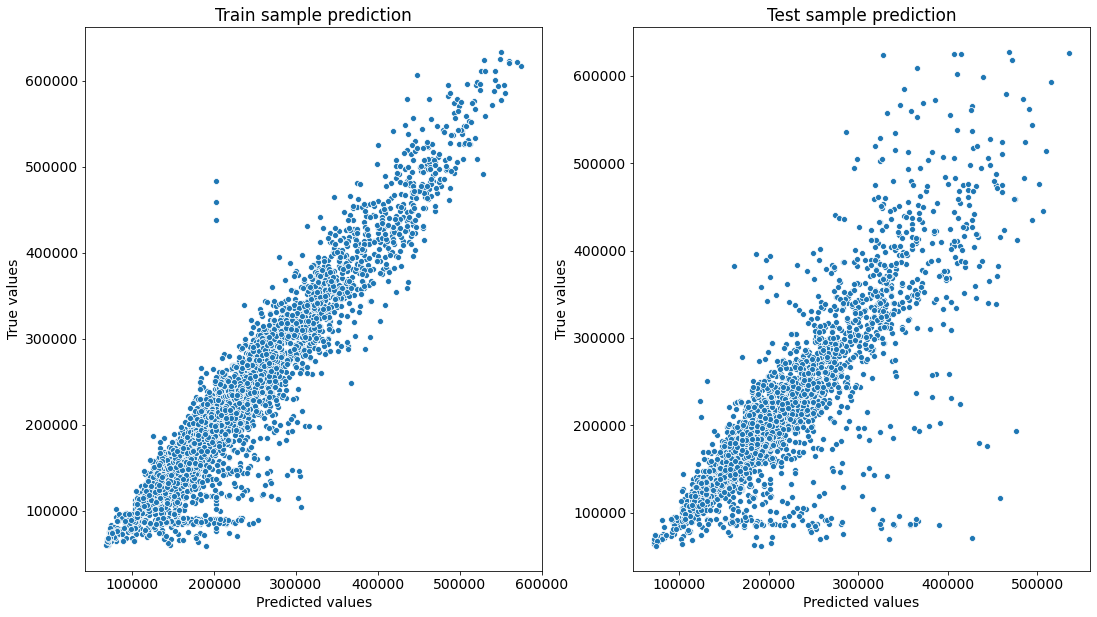

In [12727]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [12728]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=100))
cv_score

array([0.75409634, 0.75910225, 0.78576962])

In [12729]:
cv_score.mean()

0.7663227368526245

In [12730]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
25,MedPriceByDistrict,2.255272e-01
26,MedPriceByFloorYearSquare,1.463569e-01
1,Square,1.379740e-01
27,MedPriceByMeanSquear,9.603230e-02
0,Rooms,6.386420e-02
2,LifeSquare,6.020464e-02
22,DistrictSize,4.820213e-02
10,Social_1,2.989245e-02
11,Social_2,2.812283e-02
3,KitchenSquare,2.435579e-02


### Прогнозирование на тестовом датасете

In [12731]:
# Аналогично по ссылке прочитать фаил не получается, программа падает.
# submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [12732]:
predictions = rf_model.predict(test_df)
predictions

array([161080.99945278, 124030.51058498, 145888.85877664, ...,
       150401.3387717 , 177048.14536497, 257842.26411292])

In [12733]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161080.999453
1,5925,124030.510585
2,960,145888.858777
3,3848,138723.783119
4,746,178629.186503


In [12734]:
submit.to_csv('rf_submit3.csv', index=False)